In [104]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [110]:
img_size = 180
batch_size = 32
random_state = 71
data_dir = "Dataset"

def load_data(directory, img_size, batch_size, random_state):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        seed=random_state,
        image_size=(img_size, img_size),
        batch_size=batch_size
    )
    return dataset

dataset = load_data(data_dir, img_size, batch_size, random_state)
class_names = dataset.class_names

Found 330 files belonging to 3 classes.


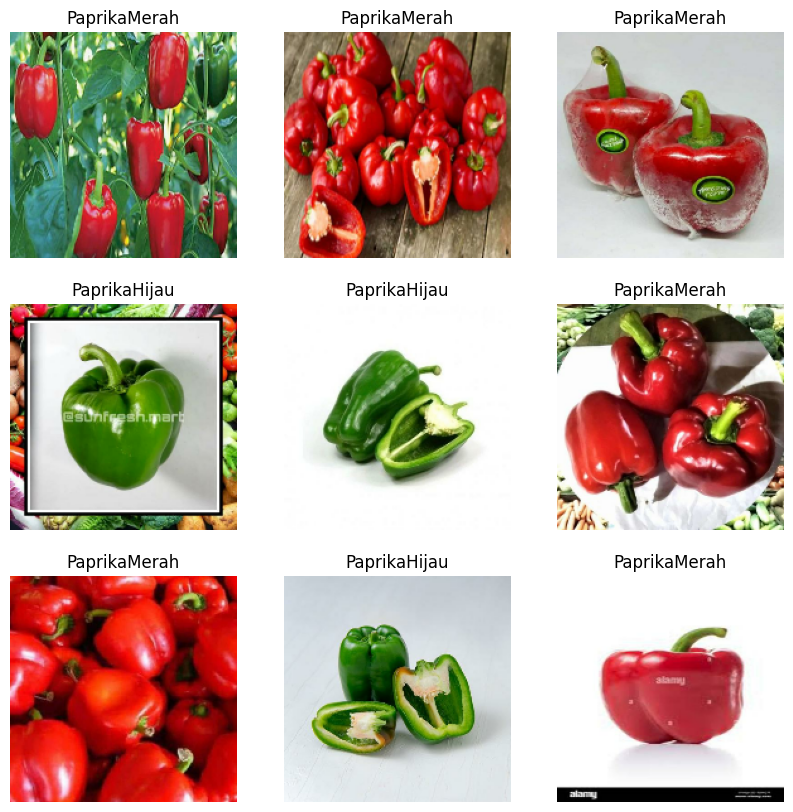

In [111]:
def visualize_data(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

visualize_data(dataset, 9)

In [112]:
val_split = 0.1
test_split = 0.1
total_count = len(dataset)
val_size = int(total_count * val_split)
test_size = int(total_count * test_split)
train_size = total_count - val_size - test_size

train_ds = dataset.skip(val_size + test_size)
val_ds = dataset.skip(test_size).take(val_size)
test_ds = dataset.take(test_size)

def normalize(image, label):
    return image / 255.0, label

In [113]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

def augment_and_normalize(image, label):
    image = data_augmentation(image)
    return normalize(image, label)

train_ds = train_ds.map(augment_and_normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

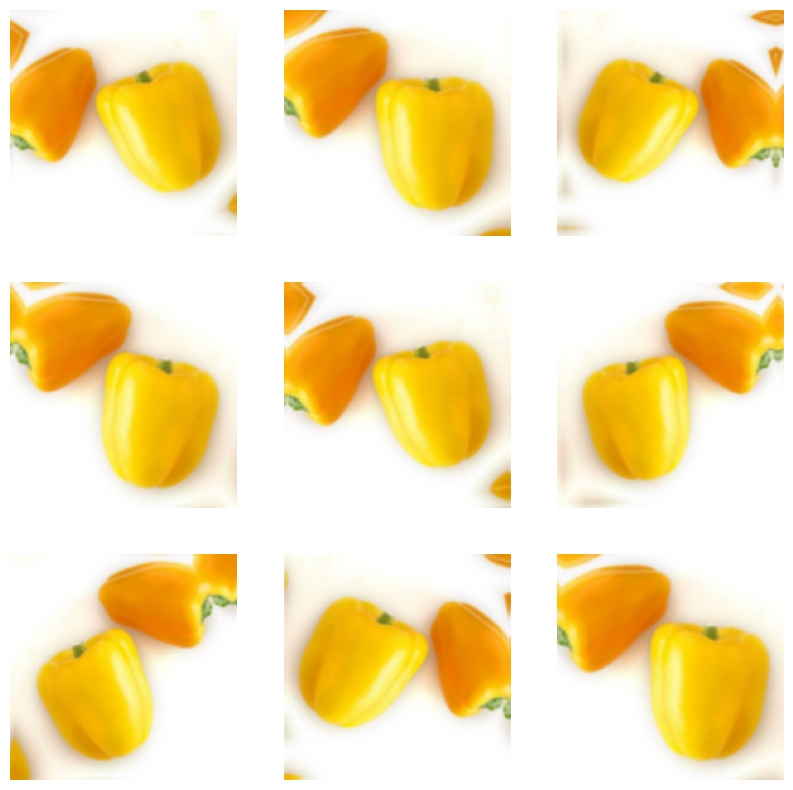

In [117]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        augmented_image = tf.clip_by_value(augmented_images[0] * 255, 0, 255)  # Scale back to 0–255
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [132]:
vgg_base = VGG16(weights=None, include_top=False, input_shape=(img_size, img_size, 3))

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,025,027 (68.76 MB)

 Trainable params: 18,025,027 (68.76 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
callbacks = [
    ModelCheckpoint("vgg16_best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3714 - loss: 1.0983 - val_accuracy: 0.5625 - val_loss: 1.0972
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 893ms/step - accuracy: 0.4101 - loss: 1.0973 - val_accuracy: 0.3750 - val_loss: 1.0968
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 887ms/step - accuracy: 0.3665 - loss: 1.0968 - val_accuracy: 0.5000 - val_loss: 1.0960
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1000ms/step - accuracy: 0.5327 - loss: 1.0944 - val_accuracy: 0.7500 - val_loss: 1.0889
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5045 - loss: 1.0900 - val_accuracy: 0.8125 - val_loss: 1.0776
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 889ms/step - accuracy: 0.6178 - loss: 1.0778 - val_accuracy: 0.7812 - val_loss: 1.0486
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 885ms/step - accuracy: 0.6529 - loss: 1.0338 - val_accuracy: 0.5938 - val_loss: 0.9586
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 902ms/step - accuracy: 0.6943 - loss: 0.9233 - val_accuracy: 0.7812 - val_loss: 0.7

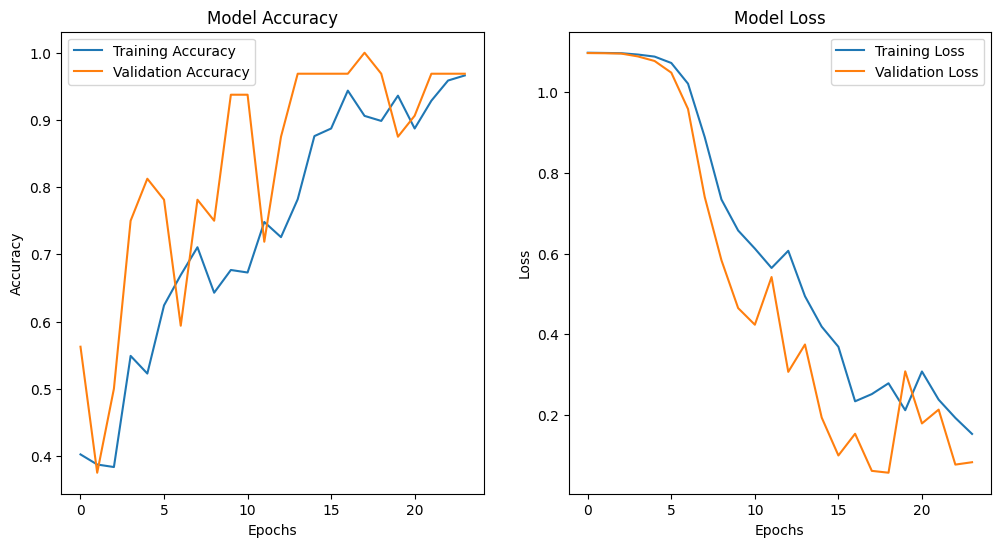

In [134]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


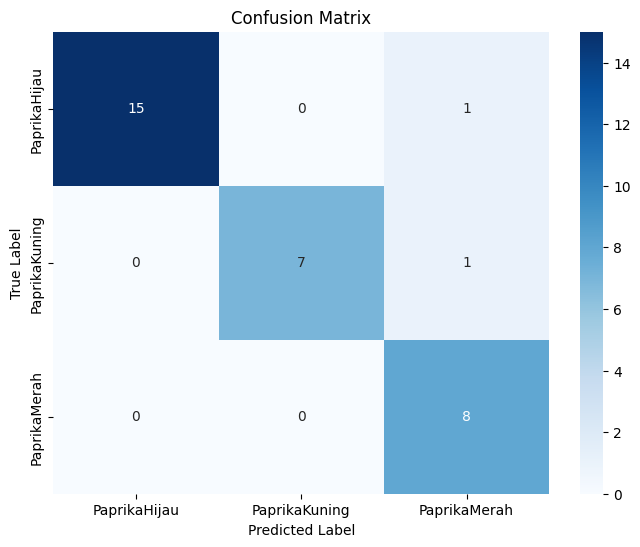

Confusion Matrix:
[[15  0  1]
 [ 0  7  1]
 [ 0  0  8]]
Accuracy: 0.9375
Precision: [1.  1.  0.8]
Recall: [0.9375 0.875  1.    ]
F1 Score: [0.96774194 0.93333333 0.88888889]


In [135]:
def evaluate_model(model, test_ds):
    test_images, test_labels = [], []
    for images, labels in test_ds:
        test_images.append(images.numpy())
        test_labels.append(labels.numpy())

    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    predictions = np.argmax(model.predict(test_images), axis=1)

    cm = confusion_matrix(test_labels, predictions)

    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

evaluate_model(model, test_ds)

In [140]:
model.save("Notebook_VGG-16_A_Seaborn_Eldan.h5")

In [139]:
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'.jpg', save_path='paprika.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediksi: PaprikaHijau
Confidence: 57.61%
Prediksi: PaprikaHijau dengan confidence 57.61%. Gambar asli disimpan di paprika.jpg.


In [142]:
print("Eliandani Andreskia Setiawan / 220711965 / Seaborn / Perbedaan Paprika Merah, Kuning, Hijau Menggunaakn VGG-16")

Eliandani Andreskia Setiawan / 220711965 / Seaborn / Perbedaan Paprika Merah, Kuning, Hijau Menggunaakn VGG-16
